In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
import sys
import os
import yaml
import matplotlib.pyplot as plt

sys.path.append(os.getenv("CODE_PATH"))
sys.path.append(os.getenv("FIN_DATABASE_PATH"))

import logging
from dotenv import load_dotenv
import ta
from log_config import setup_logging
from Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from Pre_Processing.pre_processing import PreProcessing
from Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
import backtrader as bt

In [2]:
class Strategies:
    """This class implements simple technical analysis strategies
    
    Strategy 1: Simple MA strategy based on the crossover of a short-term and a long-term moving average.
    Strategy 2: 
    Strategy 3: Mean Reversion strategy. Buy stocks whenever 2-period RSI closes below 5 and stock price is above its 200-day SMA
    
    """
    def __init__(self,df):
        self.df = df.copy()
        
    def Strategy1(self):
        self.df['strategy_1_position'] = 0
        self.df['strategy_1_position'] = np.where(self.df['sma_50'] > self.df['sma_200'], 1,
                                                np.where(self.df['sma_50'] < self.df['sma_200'], -1, 
                                                         self.df['strategy_1_position'].shift(1)
                                                         ))
        self.df['strategy_1_return'] = self.df['strategy_1_position'].shift(1) * self.df['return']
        return self   
    
    def Strategy2(self):
        self.df['strategy_2_position'] = 0
        self.df['strategy_2_position'] = np.where((self.df['close'] < self.df['lower_band']) & (self.df['IBS'] < 0.3),1,
                                       np.where((self.df['close'] > self.df['high'].shift(1)) | (self.df['close'] < self.df['sma_300']),-1,
                                                self.df['strategy_2_position'].shift(1)
                                                )
                                       )
        self.df['strategy_2_return'] = self.df['strategy_2_position'].shift(1) * self.df['return']
        return self
    
    def Strategy3(self):
        
        self.df['strategy_3_position'] = 0
        entry_signal = (self.df['RSI_2'] < 5) & (self.df['close'] > self.df['sma_200'])
        holding_period = 5
        positions = np.zeros(len(self.df))
        entry_indices = np.where(entry_signal)[0]
        
        for entry_index in entry_indices:
            end_index = min(entry_index + holding_period, len(self.df))  
            positions[entry_index:end_index] = 1  

        self.df['strategy_3_position'] = positions  

        # Step 3: Calculate Strategy Returns
        self.df['strategy_3_return'] = self.df['strategy_3_position'].shift(1) * self.df['return']

        return self

    
    def applying_strategies(self):
        self.Strategy1()
        self.Strategy2()
        self.Strategy3()
        self.df.dropna(inplace=True) 
        return self.df
    
    

In [3]:
#Getting hourly data from SQL

tickers = ['AAPL', 'MSFT', 'DIS', 'V', 'JPM']
data_dict = Pipeline(tickers).pipeline(timespan = 'hour')

In [4]:
results_dict = {}

for ticker, df in data_dict.items():
    
    strategy = Strategies(df)
    df_strategies = strategy.applying_strategies()
    
    results_dict[ticker] = df_strategies

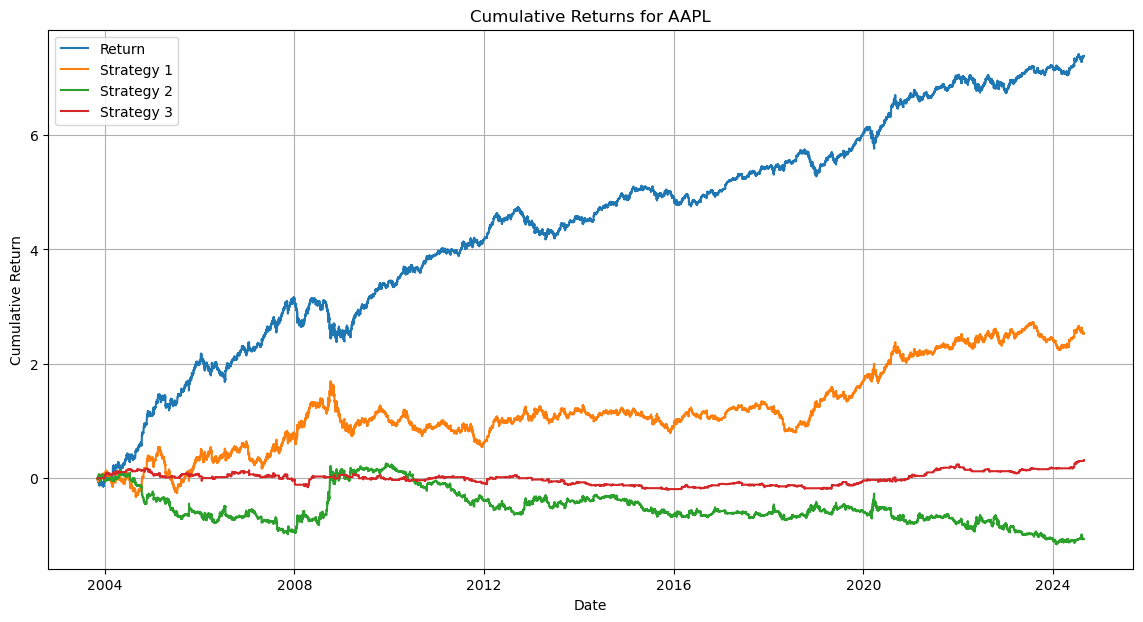

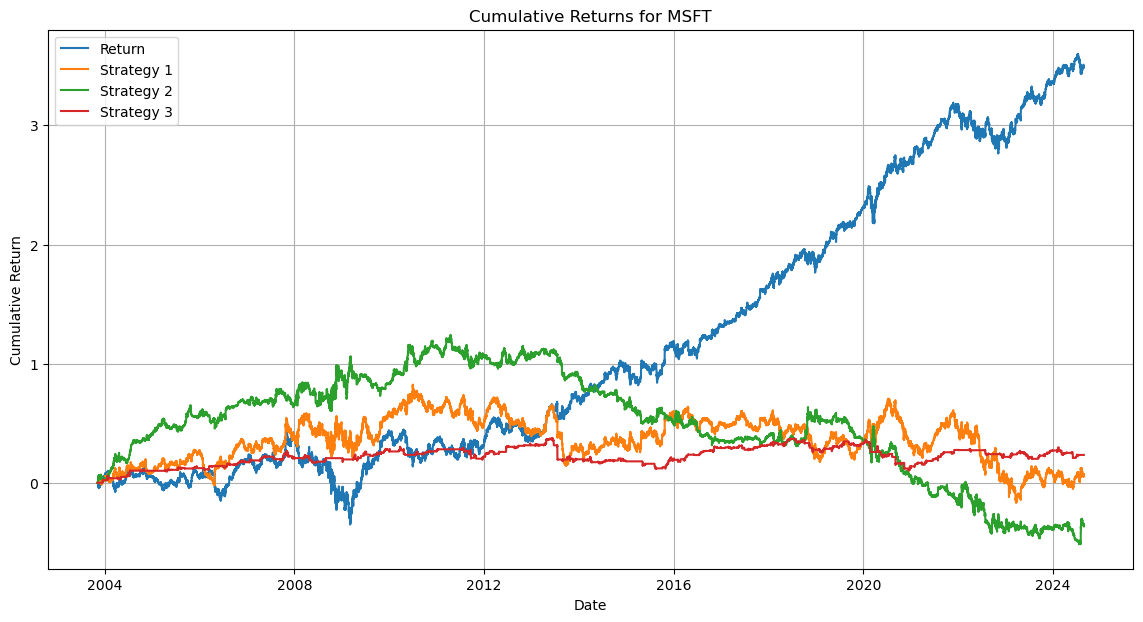

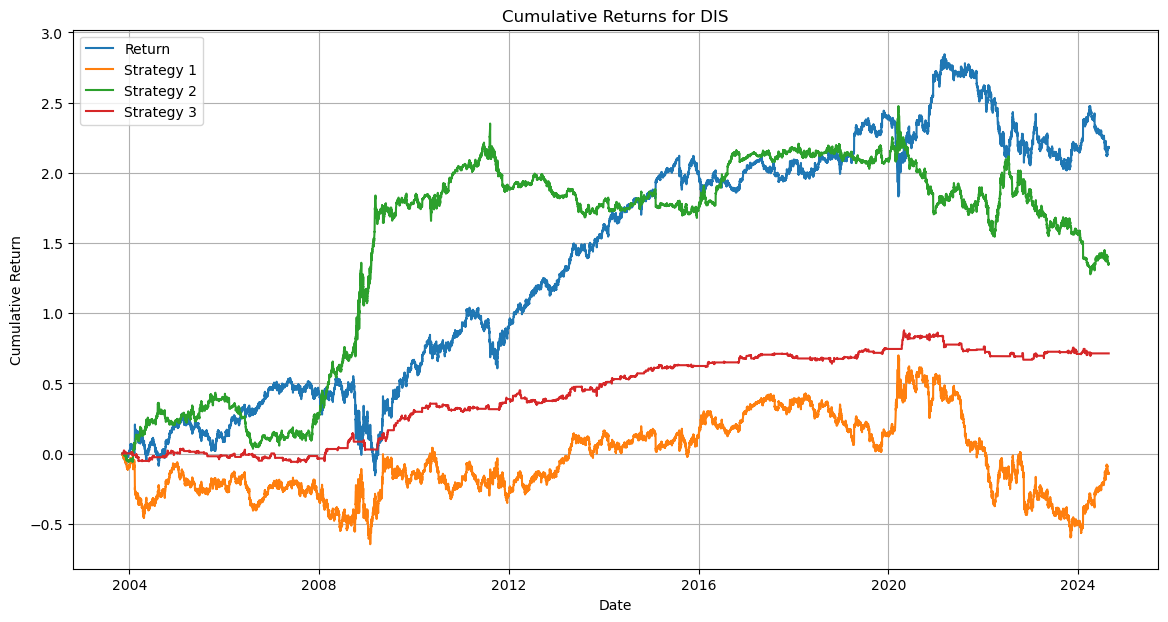

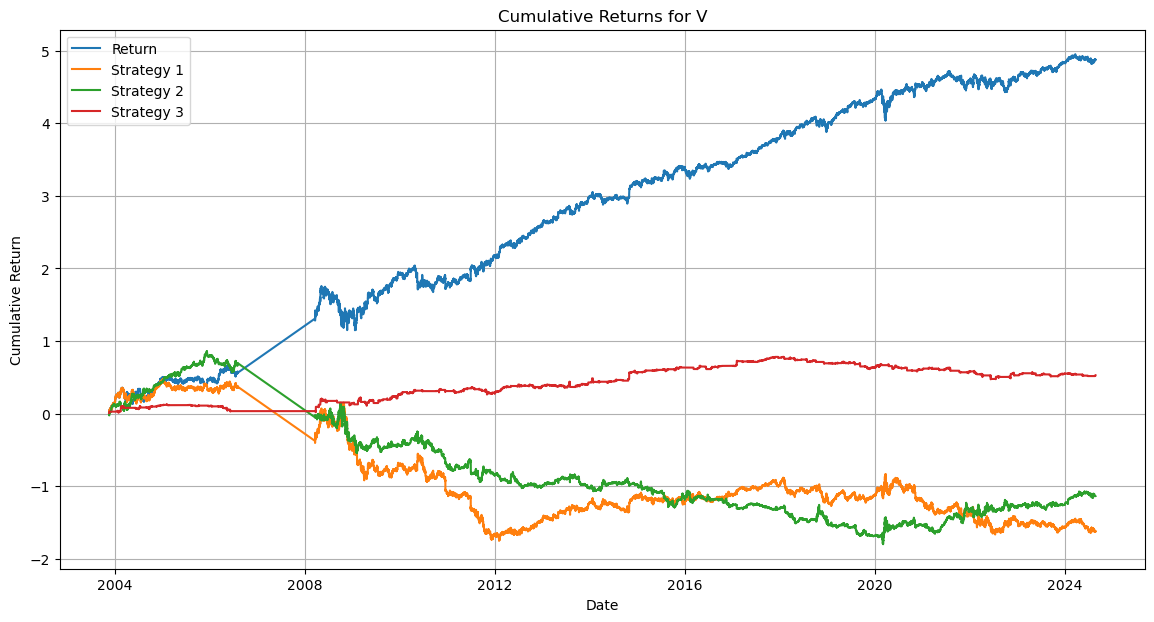

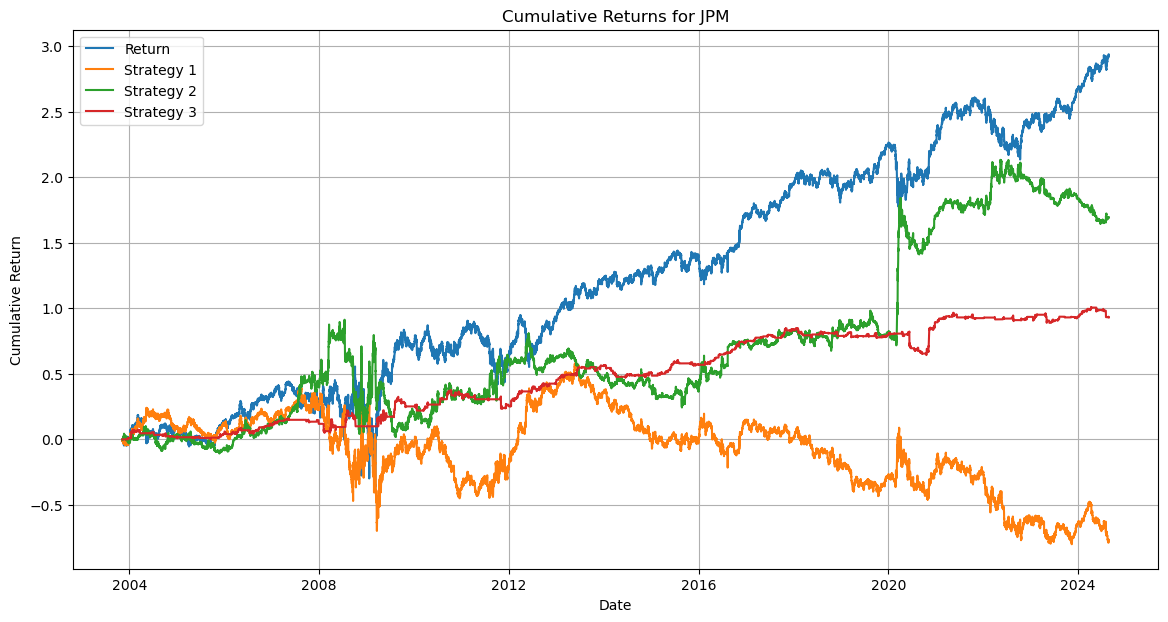

In [8]:

for ticker, df in results_dict.items():
    plt.figure(figsize=(14, 7))
    plt.title(f"Cumulative Returns for {ticker}")
    
    df['cumulative_return'] = df['return'].cumsum()
    df['cumulative_strategy_1'] = df['strategy_1_return'].cumsum()
    df['cumulative_strategy_2'] = df['strategy_2_return'].cumsum()
    df['cumulative_strategy_3'] = df['strategy_3_return'].cumsum()
    
    plt.plot(df.index, df['cumulative_return'], label='Return')
    plt.plot(df.index, df['cumulative_strategy_1'], label='Strategy 1')
    plt.plot(df.index, df['cumulative_strategy_2'], label='Strategy 2')
    plt.plot(df.index, df['cumulative_strategy_3'], label='Strategy 3')
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    
    plt.show()


In [20]:
class Strategy1(bt.Strategy):
    def __init__(self):
        self.sma_50 = bt.indicators.SimpleMovingAverage(self.data.close, period=50)
        self.sma_200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.order = None

    def next(self):
        if self.order:  # if an order is pending, do nothing
            return
        
        if self.sma_50 > self.sma_200:
            if self.position.size == 0:  # Check if we're not in a position
                self.order = self.buy()
                print(f"Buying at {self.data.close[0]}, Cash: {self.broker.get_cash()}, Value: {self.broker.get_value()}")
        
        elif self.sma_50 < self.sma_200:
            if self.position.size > 0:  # Check if we're in a position
                self.order = self.sell()
                print(f"Selling at {self.data.close[0]}, Cash: {self.broker.get_cash()}, Value: {self.broker.get_value()}")

    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.order = None  # Reset the order flag when the order completes
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.order = None  # Reset the order flag if something goes wrong


In [24]:
results_dict['AAPL']['cumulative_strategy_1']

date
2003-11-07 15:00:00   -0.016196
2003-11-07 16:00:00   -0.013702
2003-11-10 10:00:00   -0.014448
2003-11-10 11:00:00   -0.029140
2003-11-10 12:00:00   -0.026360
                         ...   
2024-08-23 12:00:00    2.523331
2024-08-23 13:00:00    2.527370
2024-08-23 14:00:00    2.528519
2024-08-23 15:00:00    2.529860
2024-08-23 16:00:00    2.530637
Name: cumulative_strategy_1, Length: 36605, dtype: float64

In [22]:
cerebro = bt.Cerebro()

cerebro.addstrategy(Strategy1)  # Or Strategy2, Strategy3

data = bt.feeds.PandasData(dataname=data_dict['AAPL'])

# Add the data to Cerebro
cerebro.adddata(data)

# Set initial capital
cerebro.broker.set_cash(100)

# Set the commission (optional)
# cerebro.broker.setcommission(commission=0.005)

# Run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())



Starting Portfolio Value: 100.00
Buying at 0.4111, Cash: 100.0, Value: 100.0
Selling at 0.3948, Cash: 99.5887, Value: 99.9835
Buying at 0.3799, Cash: 99.9835, Value: 99.9835
Selling at 0.3997, Cash: 99.596, Value: 99.9957
Buying at 0.4238, Cash: 99.9985, Value: 99.9985
Selling at 0.3986, Cash: 99.5747, Value: 99.97330000000001
Buying at 0.4291, Cash: 99.974, Value: 99.974
Selling at 0.4754, Cash: 99.5449, Value: 100.02029999999999
Buying at 0.504, Cash: 100.02029999999999, Value: 100.02029999999999
Selling at 0.5216, Cash: 99.51559999999999, Value: 100.0372
Buying at 0.5657, Cash: 100.03739999999999, Value: 100.03739999999999
Selling at 0.5706, Cash: 99.48089999999999, Value: 100.05149999999999
Buying at 0.5832, Cash: 100.05149999999999, Value: 100.05149999999999
Selling at 0.5531, Cash: 99.46829999999999, Value: 100.02139999999999
Buying at 0.6175, Cash: 100.02139999999999, Value: 100.02139999999999
Selling at 1.152, Cash: 99.40389999999998, Value: 100.55589999999998
Buying at 1.2365,

In [13]:
results_dict['AAPL']['strategy_1_return'].cumsum()

date
2003-11-07 15:00:00   -0.016196
2003-11-07 16:00:00   -0.013702
2003-11-10 10:00:00   -0.014448
2003-11-10 11:00:00   -0.029140
2003-11-10 12:00:00   -0.026360
                         ...   
2024-08-23 12:00:00    2.523331
2024-08-23 13:00:00    2.527370
2024-08-23 14:00:00    2.528519
2024-08-23 15:00:00    2.529860
2024-08-23 16:00:00    2.530637
Name: strategy_1_return, Length: 36605, dtype: float64

In [ ]:
cerebro = bt.Cerebro()

cerebro.addstrategy(Strategy1)  # Or Strategy2, Strategy3

data = bt.feeds.PandasData(dataname=msft_data)

# Add the data to Cerebro
cerebro.adddata(data)

# Set initial capital
cerebro.broker.set_cash(1000)

# Set the commission (optional)
cerebro.broker.setcommission(commission=0.005)

# Run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())



In [ ]:
from backtrader.analyzers import SharpeRatio, DrawDown

cerebro.addanalyzer(SharpeRatio, _name='sharpe')
cerebro.addanalyzer(DrawDown, _name='drawdown')

results = cerebro.run()

# Access the analyzers
sharpe = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()

print('Sharpe Ratio:', sharpe['sharperatio'])
print('Max Drawdown:', drawdown.max.drawdown)


In [ ]:
downsample_rate = 100 # Downsampling so we are able to plot 
aapl_min_down = aapl_min[::downsample_rate]



fig = go.Figure()
fig.add_trace(go.Scattergl(x = aapl_min_down.index, y = aapl_min_down['close'], mode = 'lines', name = 'AAPL', line = dict(color = 'blue')))
fig.add_trace(go.Scattergl(x = aapl_min_down.index, y = aapl_min_down['sma_50'], mode = 'lines', name = '50 Day SMA', line = dict(color = 'orange')))
fig.add_trace(go.Scattergl(x = aapl_min_down.index, y = aapl_min_down['sma_200'], mode = 'lines', name = '200 Day SMA', line = dict(color = 'green')))
fig.update_layout(
    title="AAPL 50 and 200 Day SMA",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark",
    xaxis=dict(
        tickformat="%Y-%m",
        tickangle=45,
    ),
    width=1000,
    height=600
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df.index, y=final_df['close'], mode='lines', name='AAPL', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=final_df.index, y=final_df['sma_50'], mode='lines', name='50 Day SMA', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=final_df.index, y=final_df['sma_200'], mode='lines', name='200 Day SMA', line=dict(color='green')))

# shaded regions for positions
for i in range(1, len(final_df)):
    if final_df['position'].iloc[i] == 1:
        fig.add_shape(type="rect",
                      x0=final_df.index[i-1], y0=min(final_df['close']), 
                      x1=final_df.index[i], y1=max(final_df['close']),
                      fillcolor="green", opacity=0.3, line_width=0)
    elif final_df['position'].iloc[i] == -1:
        fig.add_shape(type="rect",
                      x0=final_df.index[i-1], y0=min(final_df['close']), 
                      x1=final_df.index[i], y1=max(final_df['close']),
                      fillcolor="red", opacity=0.3, line_width=0)


fig.update_layout(
    title="AAPL 50 and 200 Day SMA with Positions",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark",
    xaxis=dict(
        tickformat="%Y-%m",
        tickangle=45,
    ),
    width=1000,
    height=600
)

fig.show()
